In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vivarium.test_util import setup_simulation, pump_simulation

In [2]:
np.random.seed(12345)  # set random seed for reproducibility

n_simulants = 50
n_days = 5000
t_timestep = 1 # days
t_start = pd.Timestamp('1990-01-01')

# Firefly micromechanism

Each agent is a firefly.  It has a clock, and at time 0 it lights up.  It also has neighbors, and if it sees a neighbor light up before it does, it jumps its clock forward one.  This should lead all fireflies to sync up.

In [6]:
def is_glowing(df):
    return (df.glow_clock % 10) < 1


is_glowing(pd.DataFrame({'glow_clock':np.random.uniform(low=0, high=100, size=25)})).value_counts()

False    24
True      1
Name: glow_clock, dtype: int64

In [10]:
class BasePopulation:
    
    def setup(self, builder):
        columns = ['glow_clock', 'sex', 'glow']
        self.population_view = builder.population.get_view(columns)
        builder.population.initializes_simulants(self.initialize_simulants, 
                                                 creates_columns=columns)

    def initialize_simulants(self, pop_data):        
        pop = pd.DataFrame({'glow_clock': np.random.uniform(low=0, high=10, size=len(pop_data.index)),
                            'sex': '-',}, index=pop_data.index)
        pop['glow'] = is_glowing(pop)
        
        self.population_view.update(pop)
        
class GlowObserver:
    def __init__(self):
        self.glow_mean = []
        
    def setup(self, builder):
        self.population_view = builder.population.get_view(['glow'])
        builder.event.register_listener('collect_metrics', self.on_collect_metrics)
        
    def on_collect_metrics(self, event):
        pop = self.population_view.get(event.index)
        self.glow_mean.append(pop.glow.mean())


In [11]:
components = [BasePopulation(), GlowObserver()]
simulation = setup_simulation(components, population_size=n_simulants, start=t_start)
pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

# take a look at the population at the end of the sim
simulation.population.population.glow.mean()

VBox(children=(HTML(value=''), IntProgress(value=0, max=5000)))

0.16

In [14]:
class IndependentGlowClock:
    def setup(self, builder):
        self.population_view = builder.population.get_view(columns=['glow_clock', 'glow'])
        
        builder.event.register_listener('time_step', listener=self.advance_clock)

    def advance_clock(self, event):
        t = self.population_view.get(event.index)
        t['glow_clock'] += np.random.uniform(low=0, high=.1, size=len(t))
        t['glow'] = is_glowing(t)
        self.population_view.update(t)

In [15]:
observer = GlowObserver()
components = [BasePopulation(), IndependentGlowClock(), observer]
simulation = setup_simulation(components, population_size=n_simulants, start=t_start)
%time pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))


# take a look at the population at the end of the sim
simulation.population.population.glow.mean()

VBox(children=(HTML(value=''), IntProgress(value=0, max=5000)))

CPU times: user 20.4 s, sys: 182 ms, total: 20.6 s
Wall time: 20.4 s


0.1

(-249.95000000000002, 5248.95, -0.014000000000000002, 1)

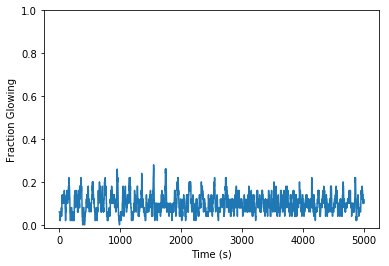

In [16]:
plt.plot(observer.glow_mean)
plt.xlabel('Time (s)')
plt.ylabel('Fraction Glowing')
plt.axis(ymax=1)

In [18]:
def my_rewired_band(n, k, p):
    """ SW Network
    k : int, width of band-1/2
    p : probability of rewiring
    """
    A = np.eye(n)
    for i in range(n):
        for j in range(i-k, i+k+1):
            if np.random.uniform() < p:
                A[i, np.random.randint(n)] = 1
            else:
                A[i, (j % n)] = 1
    return A


In [19]:
class Synchronize:
    
    def setup(self, builder):
        builder.population.initializes_simulants(self.on_initialize_simulants)        
        self.population_view = builder.population.get_view(['glow', 'glow_clock'])
        
        builder.event.register_listener('time_step', self.advance_clock)
        
    def on_initialize_simulants(self, pop_data):
        self.adjacency_matrix = my_rewired_band(len(pop_data.index), k=5, p=.2).astype(bool)
        
    def advance_clock(self, event):
        t = self.population_view.get(event.index)
    
        see_glow = self.neighbors_glowing(t.glow)
        advance_clock = see_glow & (t.glow_clock % 10 >= 5)
        t.glow_clock[advance_clock] += np.random.uniform(low=0, high=.1, size=sum(advance_clock))    
        self.population_view.update(t)

    def neighbors_glowing(self, glow):
        neighbor_glow = np.dot(self.adjacency_matrix, glow)
        return neighbor_glow > 0

In [23]:
observer = GlowObserver()
components = [BasePopulation(), IndependentGlowClock(), Synchronize(), observer]
simulation = setup_simulation(components, population_size=n_simulants, start=t_start)
%time pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))


# take a look at the population at the end of the sim
simulation.population.population.glow.mean()    

VBox(children=(HTML(value=''), IntProgress(value=0, max=5000)))

/home/james/miniconda3/envs/vivarium_examples/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 3min 56s, sys: 396 ms, total: 3min 56s
Wall time: 3min 56s


0.22

Text(0,0.5,'Fraction Glowing')

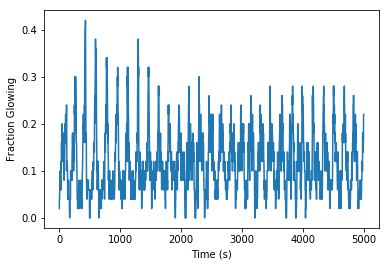

In [24]:
plt.plot(observer.glow_mean)
plt.xlabel('Time (s)')
plt.ylabel('Fraction Glowing')